In [ ]:
import sqlite3
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
import folium

# Market Analysis

In [2]:
takeaway_db = './Databases/takeaway.db'
deliveroo_db ='./Databases/deliveroo.db'
ubereats_db ='./Databases/ubereats.db'

def query_db(query, db):
    conn = sqlite3.connect(db)
    with conn:
        res = pd.read_sql_query(query, conn)
    if conn:
        conn.close()
    return res

## Map locations offering kapsalons and their average price.

### Deliveroo

In [100]:
query = """
    SELECT restaurants.name as name, ROUND(AVG(menu_items.price), 2) as avg_price, 
    restaurants.latitude as latitude, restaurants.longitude as longitude
    FROM menu_items
    JOIN restaurants ON restaurants.id = menu_items.restaurant_id
    WHERE menu_items.name LIKE "%kapsalon%"
    GROUP BY restaurants.name;
"""

data_deliveroo = query_db(query, deliveroo_db)

In [101]:
geo_data_deliveroo = gpd.GeoDataFrame(data_deliveroo, geometry=gpd.points_from_xy(data_deliveroo.longitude, data_deliveroo.latitude), crs="EPSG:4326")

In [ ]:
geo_data_deliveroo.explore()

### TakeAway

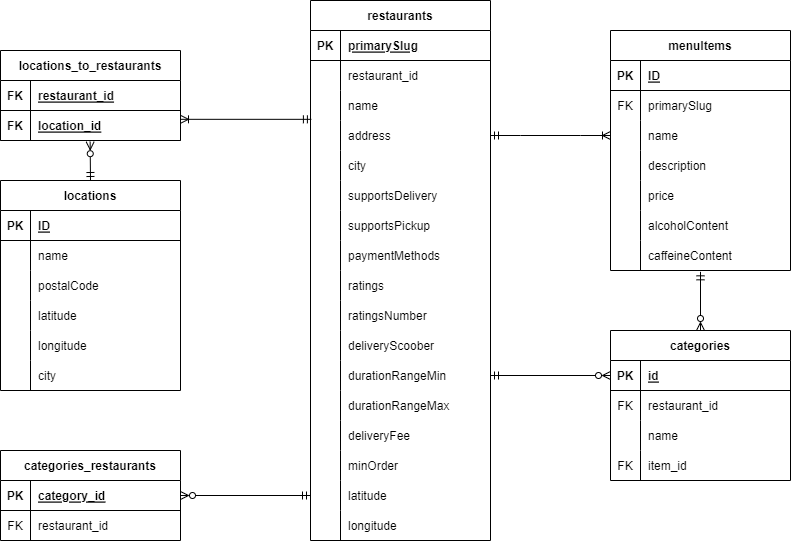

In [ ]:
query = """
    SELECT restaurants.primarySlug as name, ROUND(AVG(menuItems.price), 2) as avg_price, 
    restaurants.latitude as latitude, restaurants.longitude as longitude
    FROM menuItems
    JOIN restaurants ON restaurants.primarySlug = menuItems.primarySlug
    WHERE menuItems.name LIKE "%kapsalon%"
    GROUP BY restaurants.primarySlug;
"""

data_takeaway = query_db(query, takeaway_db)

In [78]:
geo_data_takeaway = gpd.GeoDataFrame(data_takeaway, geometry=gpd.points_from_xy(data_takeaway.longitude, data_takeaway.latitude), crs="EPSG:4326")

In [79]:
geo_data_takeaway.explore()

### UberEats

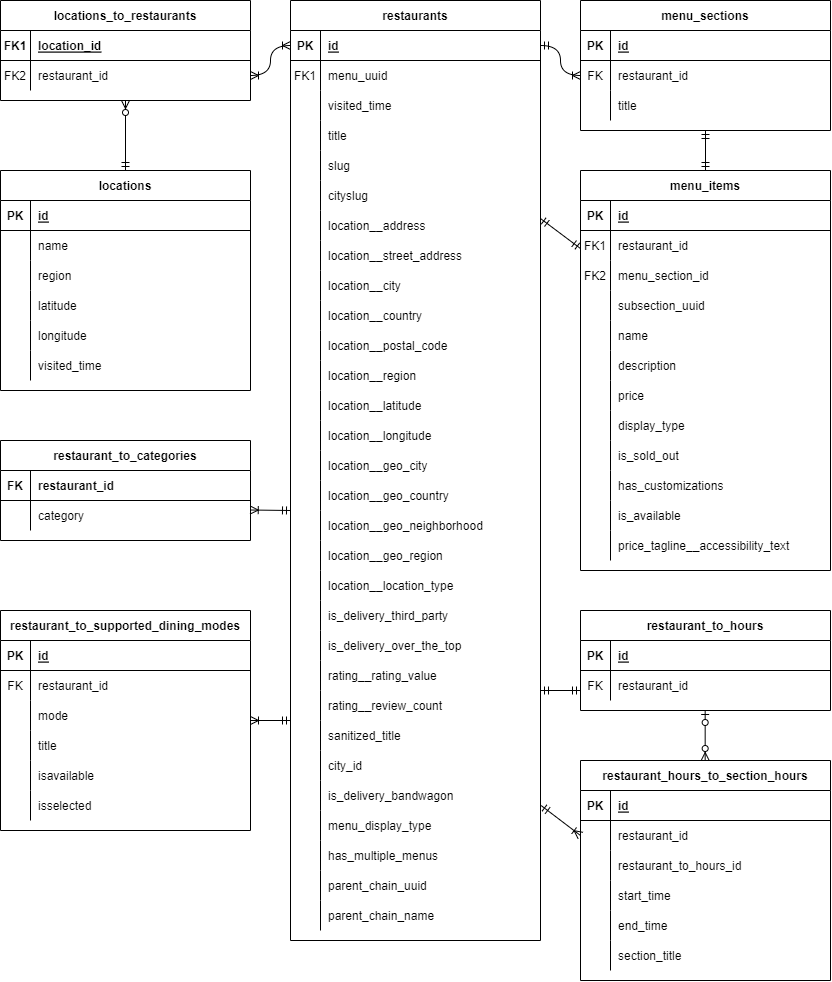

In [ ]:
query = """
    SELECT restaurants.sanitized_title as name, ROUND(AVG(menu_items.price / 100), 2) as avg_price, 
    restaurants.location__latitude as latitude, restaurants.location__longitude as longitude
    FROM menu_items
    JOIN restaurants ON restaurants.id = menu_items.restaurant_id
    WHERE menu_items.name LIKE "%kapsalon%"
    GROUP BY restaurants.sanitized_title;
"""

data_ubereats = query_db(query, ubereats_db)

In [87]:
geo_data_ubereats = gpd.GeoDataFrame(data_ubereats, geometry=gpd.points_from_xy(data_ubereats.longitude, data_ubereats.latitude), crs="EPSG:4326")

In [88]:
geo_data_ubereats.explore()

## Where are the delivery ‘dead zones’—areas with minimal restaurant coverage?

In [98]:
def restos_to_density_map(df, filename):
    try:
        geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

        min_lat, max_lat = 50.704501, 51.508238
        min_lon, max_lon = 2.541120, 5.853457

        boundary_coords = [(min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat), (min_lon, min_lat)]
        boundary = Polygon(boundary_coords)

        coverage_radius = 0.15
        gdf['buffer'] = gdf.geometry.buffer(coverage_radius)

        covered_area = unary_union(gdf['buffer'])
        dead_zones = boundary.difference(covered_area)
        
        pop_data = gpd.read_file("TF_POPULATION_GRID_3035_20200101.geojson")
        pop_data = pop_data.to_crs("EPSG:4326")

        m = folium.Map(location=[50.851409, 4.350694], zoom_start=8)

        for idx, row in df.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=1,
                color='black',
                fill=True,
                fill_color='black',
                fill_opacity=1,
            ).add_to(m)

        folium.GeoJson(
            dead_zones,
            style_function=lambda x: {'color': '#595959', 'fillOpacity': 0.3}
        ).add_to(m)

        folium.GeoJson(
            pop_data,
            style_function=lambda feature: {
                'fillColor': '#ff6600' if feature['properties']['ms_population_20200101'] > 1000 else '#ffff00',
                'color': '#000000',
                'weight': 0.5,
                'fillOpacity': 0.3,
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['ms_population_20200101'],
                aliases=['Population'],
                localize=True
            )
        ).add_to(m)

        m.save(f"./maps/{filename}.html")        
    except:
        return Exception

### Deliveroo

In [96]:
query = """
    SELECT latitude, longitude
    FROM restaurants;
"""

data_deliveroo = query_db(query, deliveroo_db)
data_deliveroo.astype(float)

,latitude,longitude
0,50.855476,4.399550
1,50.794531,4.334645
2,50.792346,4.352460
3,50.792341,4.351862
4,50.848879,4.433540
...,...,...
2711,51.205810,4.470221
2712,50.879296,4.706208
2713,51.169475,4.137958
2714,51.219129,4.419331


In [99]:
restos_to_density_map(data_deliveroo, "combined_deliveroo_restos_population_density_map")

C:\Users\zelim\AppData\Local\Temp\ipykernel_63468\40523098.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf.geometry.buffer(coverage_radius)


### Takeaway

In [89]:
query = """
    SELECT latitude, longitude
    FROM restaurants
    WHERE latitude > 0;
"""

data_takeaway = query_db(query, takeaway_db)
data_takeaway.astype(float)

,latitude,longitude
0,50.743630,3.216888
1,50.540992,5.460752
2,50.675491,5.480206
3,50.684180,5.549703
4,50.663340,5.512421
...,...,...
4048,50.805719,3.872587
4049,50.870853,4.018145
4050,50.836477,4.026344
4051,50.762280,3.862852


In [91]:
restos_to_density_map(data_takeaway, "combined_takeaway_restos_population_density_map")

C:\Users\zelim\AppData\Local\Temp\ipykernel_63468\4128076787.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf.geometry.buffer(coverage_radius)


### UberEats

In [104]:
query = """
    SELECT location__latitude as latitude, location__longitude as longitude
    FROM restaurants;
"""

data_ubereats = query_db(query, ubereats_db)
data_ubereats.astype(float)

,latitude,longitude
0,51.056860,3.737415
1,51.188560,4.425970
2,50.928600,4.422260
3,51.197890,4.425630
4,51.240870,4.439240
...,...,...
2724,50.878698,4.700045
2725,50.839031,4.285931
2726,50.717330,4.396220
2727,51.205427,4.472862


In [107]:
restos_to_density_map(data_ubereats, "combined_ubereats_restos_population_density_map")

C:\Users\zelim\AppData\Local\Temp\ipykernel_63468\40523098.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf.geometry.buffer(coverage_radius)


### All

In [105]:
df = pd.concat([data_deliveroo, data_takeaway, data_ubereats], axis=0, ignore_index=True)

In [106]:
restos_to_density_map(df, "combined_all_restos_population_density_map")

C:\Users\zelim\AppData\Local\Temp\ipykernel_63468\40523098.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf.geometry.buffer(coverage_radius)
